In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier


Import the required libaries that will be used to train/test and build the models to predict the UFC matches.

In [81]:
df = pd.read_csv('ufc-fighters-statistics.csv')
fights_df = pd.read_csv('fight_history.csv')

Read in the UFC fighter's statistics CSV file.  This file contains all of the statistics required to predict UFC matches for every fighter under the UFC organisation.

In [82]:

def data_preprocess(df):
    try:
        df['total_fights'] = df['wins'] + df['losses'] + df['draws']
        df['win_percentage'] = df.apply(lambda row: (row['wins']) / row['total_fights'] * 100 if row['total_fights'] > 0 else 0, axis=1)
        
        df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%d/%m/%Y').dt.year
        current_year = datetime.now().year
    
        df['age'] = (current_year - df['date_of_birth'])
        df = df[df['age'] < 45]

        df['losses'] = - df['losses']

        df = df.drop(columns=['date_of_birth','draws','reach_in_cm'])
        return df
    except (KeyError, TypeError) as e:
        print('error')
        
fighters_df = data_preprocess(df)
fighters_df = fighters_df.drop(columns=['stance','nickname'])

C:\Users\Josh\AppData\Local\Temp\ipykernel_14068\2932234672.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['losses'] = - df['losses']


In order to use the fighers age as a feature, the format had to be changed from DD/MM/YYYY to an integer value.  The year of the fighters birth is subtracted from the current year, to give the age.  

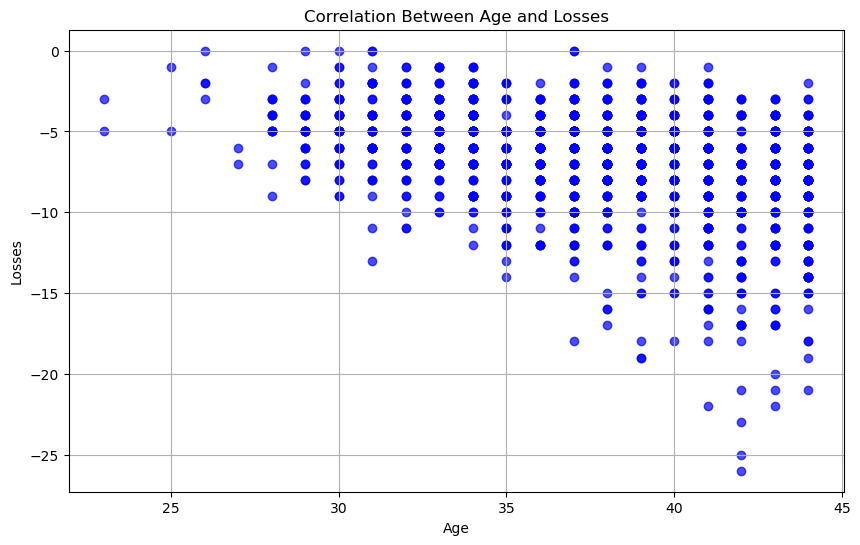

In [ ]:
filtered_fighters = fighters_df[fighters_df['total_fights'] > 15]


plt.figure(figsize=(10, 6))
plt.scatter(filtered_fighters['age'], filtered_fighters['losses'], alpha=0.7, color='blue')
plt.xlabel('Age')
plt.ylabel('Losses')
plt.title('Correlation Between Age and Losses')
plt.grid(True)
plt.show()


Plotting the age and losses to a graph, we can see a connection between a fighter aging and their losses.

In [ ]:
fights_df = fights_df[fights_df['Winner'] !='Draw'] # Removes the draws

fights_df['Winner'] = fights_df['Winner'].apply(lambda x: 1 if x == 'Red' else 0) # Changes the winner to 1 if red won and 0 if blue won.
fights_df = fights_df.rename(columns={'R_fighter':'1' , 'B_fighter':'0'})   # Changes the column titles to 1 for red and 0 for blue.
fights_df.head()

,1,0,Winner
0,Adrian Yanez,Gustavo Lopez,1
1,Trevin Giles,Roman Dolidze,1
2,Tai Tuivasa,Harry Hunsucker,1
3,Cheyanne Buys,Montserrat Conejo,0
4,Marion Reneau,Macy Chiasson,0


In the raw dataset the fighters have the features wins, losses and draws.  This can be problematic for predicting UFC bouts as the algorithm may struggle to understand the implications of a loss compared to a win.  Instead of having 3 different features for a fighters record, the wins and losses, the algorithm will use a new feature called 'win_percentage' which takes the number in the wins column for every fighter and divides it by their combined number of UFC fights.  The result is then multiplied by 100 to return a percentage of win rate.  

In [85]:
features = fighters_df

fights_with_stats = fights_df.merge(
    features.add_suffix('_A'), left_on='1', right_on='name_A').drop(columns=["name_A"])

fights_with_stats = fights_with_stats.merge(
    features.add_suffix('_B'), left_on='0', right_on='name_B').drop(columns=['name_B'])

As 2 different data sets have been imported in, one holding the fight statistics and one holding previous fights in the UFC and who won them, the datasets have been combined so that the models can take the input features (statistics) and use these to predict the winner.  

In [86]:

fights_with_stats = fights_with_stats.dropna()


X = fights_with_stats.drop(columns=['1','0','Winner'])
y = fights_with_stats['Winner']

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)


X_scale = pd.DataFrame(X_scale, columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2)

In order to give the models data, the features have been assigned to 'X' and the target variable has been set to 'y'.  Using the combined dataset, the target variable can now be set to the 'winner' column.  This allows the model to train and learn the importance of the different statistics.

Random Forest: 
Accuracy: 0.6877 ± 0.0169
F1 Score: 0.6807 ± 0.0235

SVM: 
Accuracy: 0.7041 ± 0.0161
F1 Score: 0.6965 ± 0.0197

LogisticRegression: 
Accuracy: 0.7019 ± 0.0093
F1 Score: 0.6950 ± 0.0095

Neural Network: 
Accuracy: 0.6499 ± 0.0187
F1 Score: 0.6634 ± 0.0183



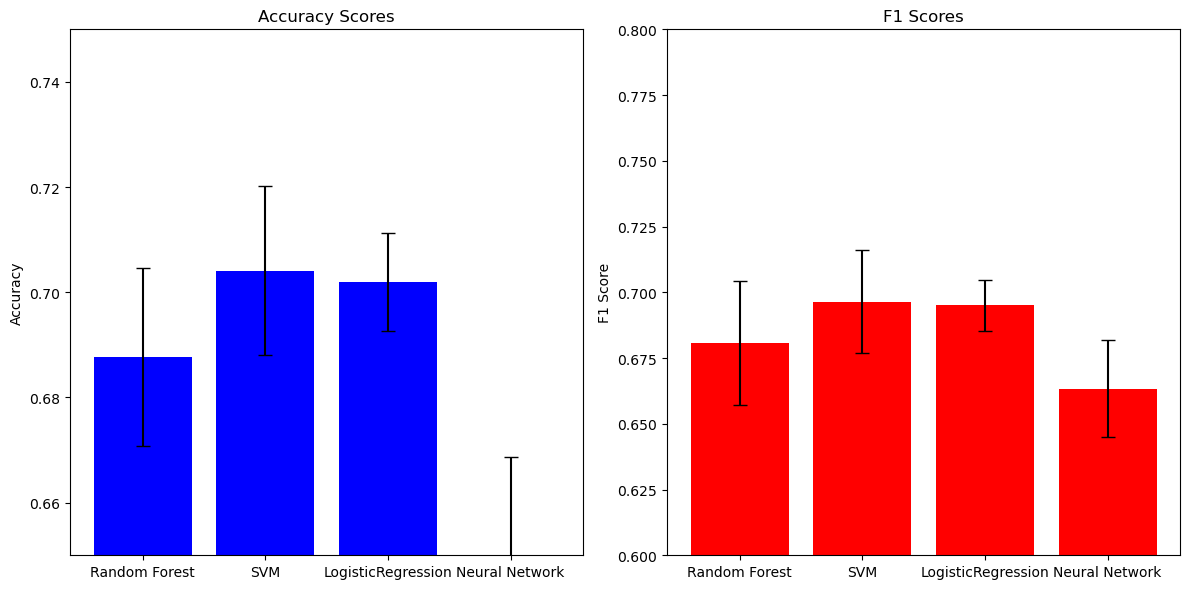

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(kernel='rbf'),
    'LogisticRegression': LogisticRegression(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000)
}

cv = StratifiedKFold(n_splits = 6, shuffle = True, random_state = 4)
f1_scorer = make_scorer(f1_score, average = 'weighted')

model_name = []
accuracy_mean = []
accuracy_std = []
f1_mean = []
f1_stds = []

for name, model in models.items():
    print(f'{name}: ')
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    accuracy_mean.append(np.mean(accuracy_scores))
    accuracy_std.append(np.std(accuracy_scores))
    f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    f1_mean.append(np.mean(f1_scores))
    f1_stds.append(np.std(f1_scores))

    print(f'Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}')
    print(f'F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}\n')
    model_name.append(name)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Accuracy
ax[0].bar(model_name, accuracy_mean, color='blue', yerr=accuracy_std, capsize=5)
ax[0].set_title('Accuracy Scores')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.65, 0.75)

# Plot F1 Score
ax[1].bar(model_name, f1_mean, color='red', yerr=f1_stds, capsize=5)
ax[1].set_title('F1 Scores')
ax[1].set_ylabel('F1 Score')
ax[1].set_ylim(0.6, 0.8)

plt.tight_layout()
plt.show()

Using a 6 fold k-fold cross validation, we can see which model is most optimal for the dataset and making predictions.  To get a gauge on the accuracy, we use the f1 score and the accuracy metrics.  Despite the close similarities in their scores, the logistic regression algorithm slightly out performs the SVM in most iterations of the program.  The evaluation also returns a range measure to ensure the difference in each folds accuracy is similar.

Feature Importance
wins:   0.1973
losses:  -0.0213
height_cm:   0.0611
weight_in_kg:   0.0571
significant_strikes_landed_per_minute:   0.2922
significant_striking_accuracy:   0.1324
significant_strikes_absorbed_per_minute:  -0.2160
significant_strike_defence:  -0.0233
average_takedowns_landed_per_15_minutes:   0.0838
takedown_accuracy:   0.0180
takedown_defense:   0.2131
average_submissions_attempted_per_15_minutes:   0.1099
total_fights:   0.1438
win_percentage:   0.4916
age:  -0.0052


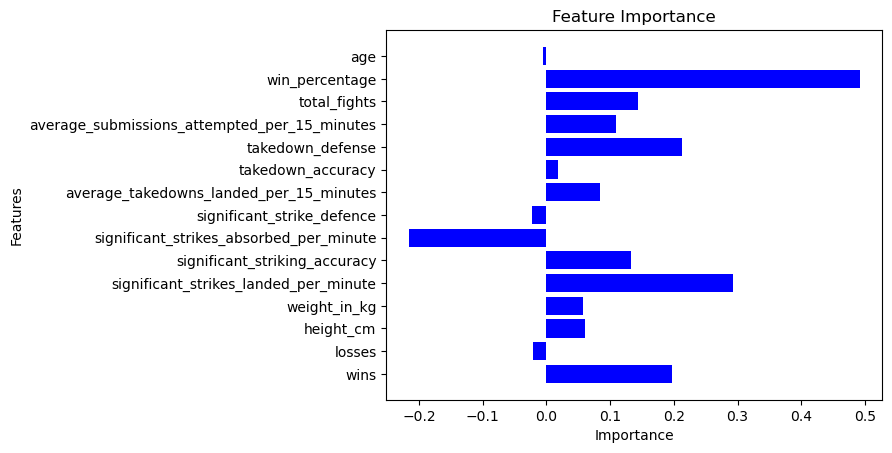

In [88]:

model = LogisticRegression()
model.fit(X_train, y_train)

coefficients = model.coef_[0]
feature_names = X_train.columns

features = []
coefs = []

print('Feature Importance')
for feature, coef in zip(feature_names, coefficients):
    if feature.endswith('_A'):
        feature_name = feature.replace('_A','')
        features.append(feature_name.replace('_A', ''))
        coefs.append(coef)
        print(f'{feature_name}:  {coef: .4f}')

for name, coef in zip(feature_names, coefficients):
    if name.endswith('_A'):
        features.append(name.replace('_A', ''))
        coefs.append(coef)

plt.barh(features, coefs, color='blue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

Using the coefficients in the logisic regression algorithm, we can check how important each statistic is.  The paper explains the key facts that are learned from doing this, and what it means for UFC fight prediction models.

In [89]:
def fighter_features(fighter_name, fighters_df):
    fighter_features = fighters_df[fighters_df['name'] == fighter_name].drop(columns = ['name'])
    if fighter_features.empty:
        print(f"Fighter '{fighter_name}' not found in the dataset.")
    else:
        return fighter_features.iloc[0]

This block of code searches for the fighter's name in the dataset that the user enters, ensuring they exist within the dataset otherwise displaying an error message.

In [ ]:
def combine_features(fighter_A, fighter_B, fighters_df):
    features_A = fighter_features(fighter_A, fighters_df)
    features_B = fighter_features(fighter_B, fighters_df)

    combined_features = pd.concat([features_A.add_suffix('_A'), features_B.add_suffix('_B')]).to_frame().T
    
    return combined_features

This code combines both fighter A and fighter B's statistics into one singular dataframe.  This is done to ensure the model is using structured data, with the suffix allowing it to tell each statistic apart and each fighter apart.

Model F1 Score: 0.6851


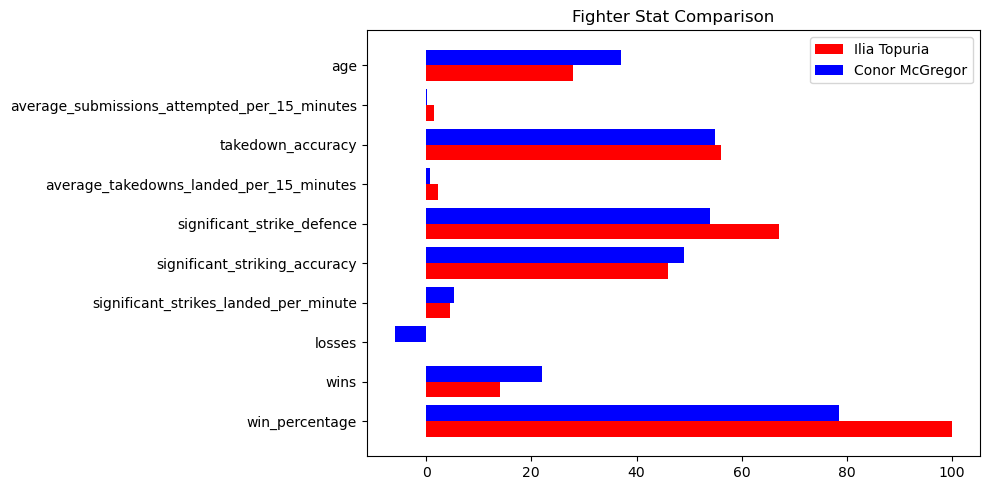

The predicted winner is: Ilia Topuria
Confidence: 81.30%


d:\Anaconda\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\Anaconda\envs\tf\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [91]:
def predict_winner(fighter_A, fighter_B, fighters_df, model, scaler):
    input = combine_features(fighter_A, fighter_B, fighters_df)
    input_scaled = scaler.transform(input)

    prediction = model.predict(input_scaled)
    probabilities = model.predict_proba(input_scaled)

    confidence = probabilities[0][prediction[0]]

    winner = fighter_A if prediction == 1 else fighter_B
    return winner, prediction, confidence

fighter_A = input('Please enter the name of fighter A: ')
fighter_B = input('Please enter the name of fighter B: ')

def compare_fighters(fighter_A, fighter_B, fighters_df):
      stats = ['win_percentage', 'wins', 'losses', 'significant_strikes_landed_per_minute', 'significant_striking_accuracy', 'significant_strike_defence', 'average_takedowns_landed_per_15_minutes', 'takedown_accuracy', 'average_submissions_attempted_per_15_minutes','age' ]
      a = fighters_df[fighters_df['name'] == fighter_A][stats].values[0]
      b = fighters_df[fighters_df['name'] == fighter_B][stats].values[0]
      plt.figure(figsize=(10, 5))
      y = range(len(stats))
      plt.barh([y-0.2 for y in y], a, height=0.4, color='red', label=fighter_A)
      plt.barh([y+0.2 for y in y], b, height=0.4, color='blue', label=fighter_B)
      plt.yticks(y, stats)
      plt.legend()
      plt.title('Fighter Stat Comparison')
      plt.tight_layout()
      plt.show()
                    


if X_test is not None and y_test is not None:
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted') 
        print(f"Model F1 Score: {f1:.4f}")

compare_fighters(fighter_A, fighter_B, fighters_df)
winner, prediction, confidence = predict_winner(fighter_A, fighter_B, fighters_df, model, scaler)
print(f"The predicted winner is: {winner}")
print(f"Confidence: {confidence * 100:.2f}%")

The final block of code takes two fighter names through user input and predicts the winner based off their statistics.  The model also returns a probability score that is labelled as the 'confidence'.  The confidence score is used in the paper to evaluate the models accuracy in relation to betting odds.  The model plots both fighters statistics against each other on a graph, allowing for a visual representation of the difference in statistics.